In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error,make_scorer
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
%matplotlib inline

In [ ]:
df = pd.read_csv('/content/TRAIN.csv')
test_df = pd.read_csv('/content/TEST_FINAL.csv')

In [ ]:
df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


In [ ]:
test_df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount
0,T1188341,171,S4,L2,R3,2019-06-01,0,No
1,T1188342,172,S1,L1,R1,2019-06-01,0,No
2,T1188343,173,S4,L2,R1,2019-06-01,0,No
3,T1188344,174,S1,L1,R4,2019-06-01,0,No
4,T1188345,170,S1,L1,R2,2019-06-01,0,No


## First Experiment  One hot encoding on all the categorical column and then using a tree model prediction of the price

In [ ]:
df_train = pd.read_csv('/content/TRAIN.csv')
df_test = pd.read_csv('/content/TEST_FINAL.csv')

In [ ]:
cat_col = df_train.drop(columns=['ID','Date','#Order','Store_id','Sales']).columns


In [ ]:
cat_col

Index(['Store_Type', 'Location_Type', 'Region_Code', 'Holiday', 'Discount'], dtype='object')

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df_train[cat_col].astype(str))
arr = enc.transform(df_train[cat_col].astype(str)).toarray()
df_train_ohe = pd.DataFrame(arr,columns=enc.get_feature_names())
df_train = df_train.drop(columns=cat_col)
df_train =pd.concat([df_train,df_train_ohe],axis=1)
test_arr = enc.transform(df_test[cat_col].astype(str)).toarray()
df_test_ohe = pd.DataFrame(test_arr,columns=enc.get_feature_names())
df_test = df_test.drop(columns=cat_col)
df_test =pd.concat([df_test,df_test_ohe],axis=1)

In [ ]:
df_train.head()

,ID,Store_id,Date,#Order,Sales,x0_S1,x0_S2,x0_S3,x0_S4,x1_L1,x1_L2,x1_L3,x1_L4,x1_L5,x2_R1,x2_R2,x2_R3,x2_R4,x3_0,x3_1,x4_No,x4_Yes
0,T1000001,1,2018-01-01,9,7011.84,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,T1000002,253,2018-01-01,60,51789.12,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,T1000003,252,2018-01-01,42,36868.20,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,T1000004,251,2018-01-01,23,19715.16,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,T1000005,250,2018-01-01,62,45614.52,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [ ]:
df_test.head()

,ID,Store_id,Date,x0_S1,x0_S2,x0_S3,x0_S4,x1_L1,x1_L2,x1_L3,x1_L4,x1_L5,x2_R1,x2_R2,x2_R3,x2_R4,x3_0,x3_1,x4_No,x4_Yes
0,T1188341,171,2019-06-01,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,T1188342,172,2019-06-01,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,T1188343,173,2019-06-01,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,T1188344,174,2019-06-01,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,T1188345,170,2019-06-01,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
df_train.to_csv('train_ohe.csv',index=False)
df_test.to_csv('test_ohe.csv',index=False)

In [ ]:
x_train = df_train.drop(columns=['ID','Date','#Order','Sales']).values
y_train = df_train.Sales.values

In [ ]:
x_test = df_test.drop(columns=['ID','Date']).values

In [ ]:
model = RandomForestRegressor(max_depth=880.0,min_samples_leaf= 0.08217361051305998,min_samples_split= 0.14270798884106353,n_estimators= 1500)
model.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=880.0, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None,
                      min_samples_leaf=0.08217361051305998,
                      min_samples_split=0.14270798884106353,
                      min_weight_fraction_leaf=0.0, n_estimators=1500,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [ ]:
model.score(x_train,y_train)

0.368143146349044

In [ ]:
y_pred_test = model.predict(x_test)

In [ ]:
prediction = pd.DataFrame(y_pred_test,columns=['Sales'])

In [ ]:
submission = pd.DataFrame(df_test.ID,columns=['ID'])

In [ ]:
submission = pd.concat([submission,prediction],axis=1)

In [ ]:
submission.to_csv('submission_3.csv',index=False)

In [ ]:
model = LGBMRegressor()
model.fit(x_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
space = {'criterion': hp.choice('criterion', ['mse']),
        'max_depth': hp.quniform('max_depth', 10, 1200, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200,1300,1500])
    }

In [ ]:
def objective(space):
    model = RandomForestRegressor(criterion = space['criterion'], max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 )
    sc = make_scorer(mean_squared_log_error)
    accuracy = cross_val_score(model, x_train, y_train,scoring=sc, cv = 5).mean()
    print(accuracy)
    
    return {'loss': accuracy, 'status': STATUS_OK }

In [ ]:
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 40,
            trials= trials)

0.17730250967778788
0.2336916765213119
0.209917679915587
0.17708407028482237
0.23369328160720468
0.2169404689828541
0.23090439092068019
0.23370295957043977
0.23369001294009015
0.23369126140198002
0.23369125026744783
0.20992212734865015
0.18096520499792904
0.15799049815158578
0.21650532064043881
0.2336789707387264
0.23369207072904694
0.23370680029371083
0.23368754540466163
0.23369817240627336
0.18298516839234508
0.16171719529814882
0.16264368247988978
0.18601583346229786
0.16301190865990728
0.18267440274763383
0.16236397127458024
0.16683246369697147
0.15663908382726494
0.20991456015660223
0.15778464796143382
0.16248927223511656
0.15530181796735892
0.20991923059079798
0.1566340924639366
0.20992174274607045
0.16239992104691697
0.2209778186407914
0.18272443605122304
0.16240084819201286
100%|██████████| 40/40 [2:33:20<00:00, 230.02s/it, best loss: 0.15530181796735892]


In [ ]:
model = RandomForestRegressor()

In [ ]:
best

{'criterion': 0,
 'max_depth': 880.0,
 'max_features': 0,
 'min_samples_leaf': 0.08217361051305998,
 'min_samples_split': 0.14270798884106353,
 'n_estimators': 6}

## FB prophet on every particular shop id and making a dictionary of the predicted dates .

In [ ]:
shop_id = list(df_train['Store_id'].value_counts().keys())

In [ ]:
answer_dict = dict()

In [ ]:
train = df_train[df_train['Store_id']==324]

In [ ]:
train = train.loc[:,['Date','Sales']]

In [ ]:
train.rename(columns = {'Date':'ds','Sales':'y'}, inplace = True) 

In [ ]:
train['ds'] = pd.to_datetime(train['ds']) 

In [ ]:
model = Prophet()
model.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future_dates=model.make_future_dataframe(periods=61)

In [ ]:
future_dates

,ds
0,2018-01-01
1,2018-01-02
2,2018-01-03
3,2018-01-04
4,2018-01-05
...,...
572,2019-07-27
573,2019-07-28
574,2019-07-29
575,2019-07-30


In [ ]:
prediction=model.predict(future_dates)

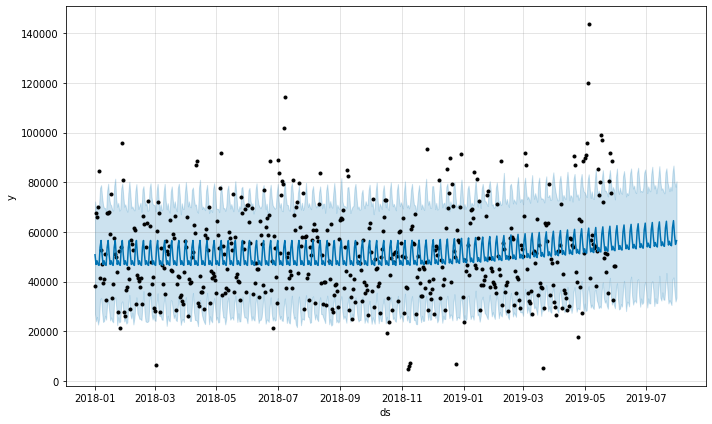

In [ ]:
model.plot(prediction);

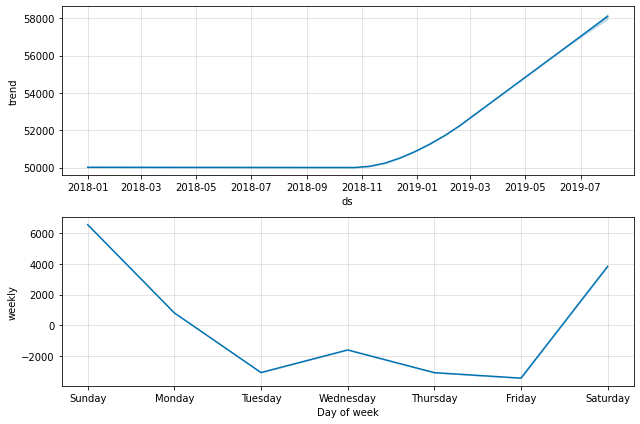

In [ ]:
model.plot_components(prediction);

In [ ]:
prediction = prediction.loc[:,['ds','yhat']]

In [ ]:
mydic = dict(zip(prediction.ds, prediction.yhat))

In [ ]:
answer_dict[324] = mydic

In [ ]:
for id in shop_id:
     train = df_train[df_train['Store_id']==id]
     train = train.loc[:,['Date','Sales']]
     train.rename(columns = {'Date':'ds','Sales':'y'}, inplace = True)
     train['ds'] = pd.to_datetime(train['ds']) 
     model = Prophet(daily_seasonality=True)
     model.fit(train)
     future_dates=model.make_future_dataframe(periods=61)
     prediction=model.predict(future_dates)
     prediction = prediction.loc[:,['ds','yhat']]
     mydic = dict(zip(prediction.ds, prediction.yhat))
     answer_dict[id] = mydic

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

In [ ]:
df_test['Date'] = pd.to_datetime(df_test['Date'])

In [ ]:
prediction = list()
for i in range(len(df_test)):
    prediction.append(answer_dict[df_test['Store_id'][i]][df_test['Date'][i]])

In [ ]:
prediction = pd.DataFrame(prediction,columns=['Sales'])
submission = pd.DataFrame(df_test.ID,columns=['ID'])
submission = pd.concat([submission,prediction],axis=1)
submission.to_csv('submission_5.csv',index=False)

In [ ]:
prediction

[63961.54436926101,
 41947.59390613319,
 78337.80615599535,
 40633.21653208954,
 43532.319992087214,
 127022.58867234242,
 76028.82340599893,
 48766.87119916177,
 58954.1618803349,
 36138.76127068793,
 55649.53696368626,
 46752.00357141833,
 46771.6347966392,
 45679.245370223594,
 49080.06501878824,
 43253.15175270918,
 43584.969614885296,
 25717.37553939083,
 33609.82660801716,
 54283.16442987001,
 34959.94949062458,
 45389.700276882155,
 47365.547489706514,
 34899.43995661025,
 53736.7842239292,
 39662.26763048592,
 40921.967732633624,
 33342.84413560269,
 38813.75874117438,
 51014.122390982695,
 40831.97892642759,
 58877.02053357903,
 40251.66611172054,
 39834.53549618838,
 104449.30220373884,
 73033.60639826221,
 39615.62621423826,
 36821.77798823384,
 33685.87135811516,
 76234.97581203461,
 34256.87569006713,
 35887.957457906115,
 36204.9587018225,
 40030.584075778286,
 50454.15207418643,
 48535.62618464673,
 65127.663194198176,
 68733.13636253189,
 30069.192355520565,
 100389.164